## Introduce

## Import and setting

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader

import time
import warnings

grey = .77, .77, .77


print('set up complete!')

set up complete!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Fit distribution

In [0]:
# Create models from data
def fit_distribution(data, DISTRIBUTIONS, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0   

    good_dists = []

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        # plt.plot(x, pdf, label='{}'.format(distribution.name))                     
                        pd.Series(pdf, x).plot(ax=ax, label='{}'.format(distribution.name))
                        pass
                    end
                except Exception:
                    pass
                 
                good_dists.append((distribution.name, sse))

        except Exception:
            pass


    return good_dists

### Choose good distribution

In [0]:
# Create models from data
def good_distribution(data, DISTRIBUTIONS, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0   

    # Compute norm sse:
    norm_loc, norm_scale = st.norm.fit(data)
    norm_pdf = st.norm.pdf(x, loc=norm_loc, scale=norm_scale)
    norm_sse = np.sum(np.power(y - norm_pdf, 2.0))
    norm_dist = [(st.norm, norm_sse)]

    # Distribution is fitter than norm
    more_than_norm_dists = []
    more_than_norm_params = []

    # Distribution is not as fit as norm
    less_than_norm_dists = []
    less_than_norm_params = []

    # best & worst distribution
    best_distributions = []
    worst_distributions = []

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        # plt.plot(x, pdf, label='{}'.format(distribution.name))                     
                        pd.Series(pdf, x).plot(ax=ax, label='{}'.format(distribution.name))
                        pass
                    end
                except Exception:
                    pass
                 
                # identify if this distribution is better
                if norm_sse > sse > 0:
                    more_than_norm_dists.append((distribution, sse))
                    more_than_norm_params.append(params)

                # identify if this distribution is worse
                if sse > norm_sse > 0:
                    less_than_norm_dists.append((distribution, sse))
                    less_than_norm_params.append(params)

                # print('huyyyyy')
                  

        except Exception:
            pass

    

   # compute best distribution is fitter than norm
    best_sses = sorted([sse for dist, sse in more_than_norm_dists])
    if len(best_sses) == 1:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]]
    elif len(best_sses) == 2:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]] 
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[1]]
    elif len(best_sses) > 2:
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[0]] 
        best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[1]]
        # best_distributions += [(dist, sse) for dist, sse in more_than_norm_dists if sse == best_sses[2]] 

    # compute best distribution is not as fit as norm
    worst_sses = sorted([sse for dist, sse in less_than_norm_dists])
    if len(worst_sses) == 1:
        worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[0]]
    elif len(worst_sses) > 1:
        worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[0]] 
        # worst_distributions += [(dist, sse) for dist, sse in less_than_norm_dists if sse == worst_sses[1]]

    return (best_distributions + worst_distributions + norm_dist)

### Compute VaR

In [0]:
def compute_VaR(distribution, data, date, n_days_calc_var=250, level_meaning=0.05, n_iters = 10, last_k_days = 1):

    n_days = data.shape[0]
    var_monte = []

    n_error = -1
    loss_accuracy = -1.0
    last_var = 0

    loss_lastkdays =  -1.0
    tssl = pd.DataFrame()
    
    try:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            
            for i in range(0, n_days - n_days_calc_var):
                var_1_time = []
                
                params = distribution.fit(data.iloc[i : i+n_days_calc_var])
                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                for _ in range(n_iters):
                    # Calculate fitted PDF and error with fit in distribution
                    monte_carlo = distribution.rvs(loc=loc, scale=scale, size = n_days_calc_var, *arg, random_state=None)
                    serie = pd.Series(monte_carlo)            
                    var_1_time.append(serie.quantile(level_meaning))

                var_monte.append(sum(var_1_time) / n_iters)

            var_monte_array = np.array(var_monte)
            tssl_array = np.array(data.iloc[n_days_calc_var:n_days])

            if last_k_days == 0:
                loss_accuracy = np.round(sum(var_monte_array > tssl_array) / (len(var_monte_array) * level_meaning), 3)
                n_error = sum(var_monte_array > tssl_array)
               
            elif last_k_days > 0:
                loss_accuracy = np.round(sum(var_monte_array[0:-last_k_days] > tssl_array[0:-last_k_days]) / (len(var_monte_array) * level_meaning), 3)
                n_error = sum(var_monte_array[0:-last_k_days] > tssl_array[0:-last_k_days]) 
                loss_lastkdays = np.round(sum(var_monte_array[-1: -last_k_days-1:-1] > tssl_array[-1: -last_k_days-1:-1]) , 3) / last_k_days
            
            tssl['Date'] = pd.Series(np.array(date.iloc[n_days_calc_var:n_days]))
            tssl['Monte_carlo'] = pd.Series(var_monte_array)
            tssl['TSSL'] = pd.Series(tssl_array)
            tssl['Error'] = tssl['Monte_carlo'] > tssl['TSSL']
            last_var = var_monte_array[-1-last_k_days-1]
            
            
    except Exception:
        pass

    return (loss_accuracy, n_error, last_var), loss_lastkdays, tssl
    

## Value at risk

### Read data & preprocessing


In [5]:

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2019-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
NAT = pandas_datareader.data.DataReader('NAT', 'yahoo', start_date, end_date)
NAT.to_csv('z.csv')
csv = pd.read_csv('z.csv', index_col=False)
data = None
data = csv.iloc[-1:0:-1].copy()

# Add profit rate column
profit_rate = []
for i in range(len(data)-1):
    profit_rate.append(data.Close.iloc[i] / data.Close.iloc[i+1] - 1)
profit_rate.append(0)
data['Profit_rate'] = profit_rate
if data.Profit_rate.isnull().any() or data.index.isnull().any():
    print('add profit rate column badly')
else:
    print('add profit rate column successfully')


data

add profit rate column successfully


,Date,High,Low,Open,Close,Volume,Adj Close,Profit_rate
2515,2019-12-31,4.970000,4.780000,4.820000,4.920000,1430500.0,4.804430,0.012346
2514,2019-12-30,4.980000,4.810000,4.810000,4.860000,2132400.0,4.745839,0.008299
2513,2019-12-27,5.080000,4.760000,5.040000,4.820000,3110400.0,4.706779,-0.043651
2512,2019-12-26,5.170000,4.880000,4.900000,5.040000,2889500.0,4.921611,0.037037
2511,2019-12-24,4.920000,4.730000,4.850000,4.860000,1398800.0,4.745839,-0.004098
...,...,...,...,...,...,...,...,...
5,2010-01-11,33.450344,32.540466,32.745922,33.235104,1251500.0,15.280799,0.040110
4,2010-01-08,32.031715,31.366426,31.405560,31.953445,500800.0,14.691519,0.008025
3,2010-01-07,31.708855,30.935944,31.425127,31.699070,535400.0,14.574560,0.011552
2,2010-01-06,31.552315,30.114117,30.192387,31.337074,825300.0,14.408127,0.043662


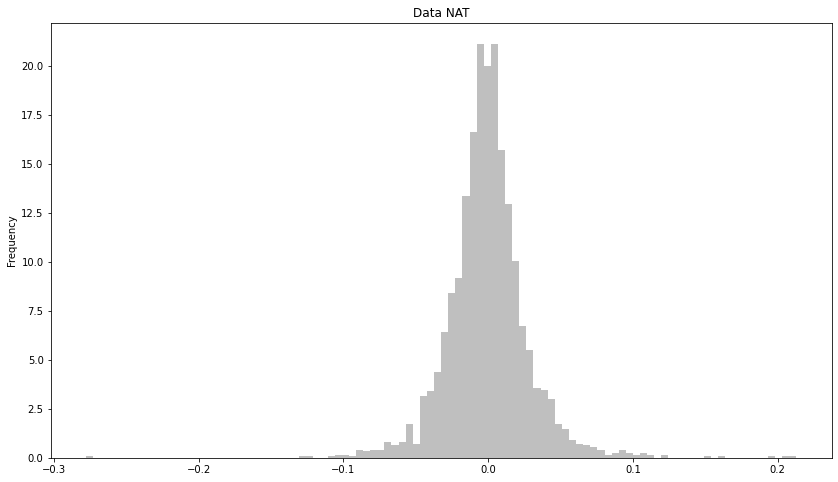

In [6]:
matplotlib.rc('figure', figsize=(14, 8))
ax = data.Profit_rate.plot(kind='hist', bins=100, density=True, alpha=0.5, color='grey', 
                           edgecolor='none', title='Data NAT')
plt.show()

### Anderson test NAT

In [7]:
from scipy.stats import anderson
(statistic, critical_values, significance_level) = anderson(data.Profit_rate, dist='norm')
# result = anderson(data)
print('Statistic: %.3f' % statistic)
p = 0
for i in range(len(critical_values)):
	sl, cv = significance_level[i], critical_values[i]
	if statistic < critical_values[i]:
		print('%.3f: %.3f, data looks normal' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal' % (sl, cv))

Statistic: 32.668
15.000: 0.575, data does not look normal
10.000: 0.655, data does not look normal
5.000: 0.786, data does not look normal
2.500: 0.917, data does not look normal
1.000: 1.090, data does not look normal


### Fit distribution

In [8]:
# Find best fit distribution
DISTRIBUTIONS = [st.t, st.logistic, st.dgamma, st.laplace, st.hypsecant,
                 st.dweibull, st.pearson3, st.gumbel_l, st.gumbel_r, st.norm]



good_dists_sses = fit_distribution(data.Profit_rate, DISTRIBUTIONS, 500)

good_dists_sorted = sorted([(dist, sse) for dist, sse in good_dists_sses], key=lambda x: x[1])
fit_dists = pd.DataFrame({'nat': [dist for dist, sse in good_dists_sorted]})
fit_dists['nat lost square'] = pd.DataFrame([sse for dist, sse in good_dists_sorted])
fit_dists.to_csv('nat_fit.csv')
fit_dists

,nat,nat lost square
0,dgamma,883.803925
1,dweibull,916.785426
2,t,945.756319
3,hypsecant,1003.511424
4,laplace,1025.475263
5,logistic,1172.261828
6,pearson3,1976.690863
7,norm,1985.426266
8,gumbel_l,5134.707633
9,gumbel_r,5471.580179


### Choose 4 good distribution, 2>norm>2

In [0]:
# Find best fit distribution
DISTRIBUTIONS = [st.t, st.logistic, st.dgamma, st.laplace, st.hypsecant,
                 st.dweibull, st.pearson3, st.gumbel_l, st.gumbel_r, st.norm]


### Plot data with distribution

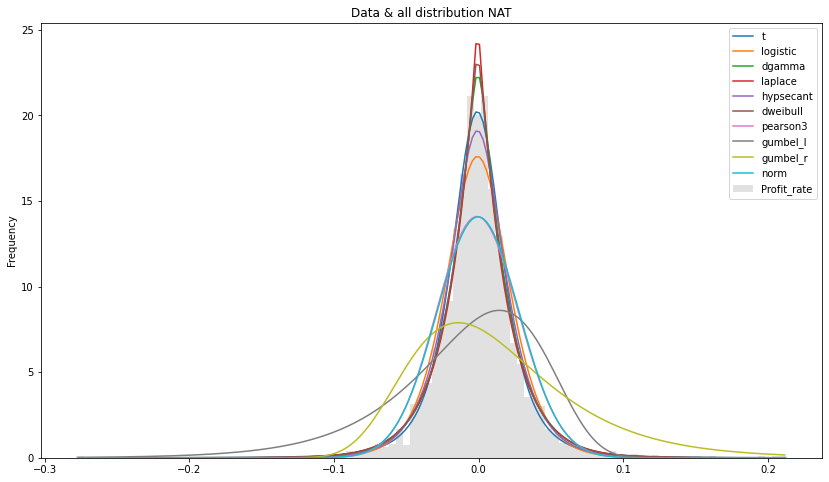

In [0]:
matplotlib.rc('figure', figsize=(14, 8))
ax = data.Profit_rate.plot(kind='hist', bins=100, density=True, alpha=0.5, color=grey, 
                           edgecolor='none', title='Data & all distribution NAT')
dist = good_distribution(data.Profit_rate, DISTRIBUTIONS, 200, ax=ax)
plt.legend(loc='best')
plt.show()

### Compute VaR and VR test

In [0]:
start_time = time.time()

last_k_days = 0
level_meanings = [0.05, 0.01]
n_iters = 100
n_days_calc_var = 1000

result = pd.DataFrame({'Distribution':[dist.name for dist in DISTRIBUTIONS]})
result['N_days'] = pd.Series([data.shape[0] - n_days_calc_var for dist in DISTRIBUTIONS])

tssl= {}
tssl[0.05] = {}
tssl[0.01] = {}

print('Data: NAT')
print('Date: {} to {}'.format(data.Date.iloc[-1], data.Date.iloc[0]))
print('----------------------------------------------')

for level_meaning in level_meanings:
    vr_losses = []
    n_errors = [] 
    last_vars = []
    
    for dist in DISTRIBUTIONS:
        (vr_loss, n_error, last_var), _, tssl[level_meaning][dist.name] = compute_VaR(dist, data.Profit_rate.iloc[::-1], data.Date.iloc[::-1], n_days_calc_var=n_days_calc_var, 
                                                                                 n_iters = n_iters, level_meaning=level_meaning, last_k_days = last_k_days)
        vr_losses.append(vr_loss)
        n_errors.append(n_error)
        last_vars.append(last_var)

    result['VR loss {}%'.format(level_meaning*100)] = pd.Series(vr_losses)
    result['Number error VaR {}%'.format(level_meaning*100)] = pd.Series(n_errors)
    result['Last VaR {}%'.format(level_meaning*100)] = pd.Series(last_vars)

print('total time train: {} (s)'.format(time.time() - start_time))
print('VR test loss_accuracy with monte carlo {} times :'.format(n_iters))
result['Last VaR Point 1%'] = (result['Last VaR {}%'.format(0.01*100)] + 1) * data.Close.iloc[1]
result['Last VaR Point 5%'] = (result['Last VaR {}%'.format(0.05*100)] + 1) * data.Close.iloc[1]
result['Last profit rate Point '] = data.Close.iloc[0]
result


Data: NAT
Date: 2010-01-05 to 2019-12-31
----------------------------------------------
total time train: 3132.184188604355 (s)
VR test loss_accuracy with monte carlo 100 times :


,Distribution,N_days,VR loss 5.0%,Number error VaR 5.0%,Last VaR 5.0%,VR loss 1.0%,Number error VaR 1.0%,Last VaR 1.0%,Last VaR Point 1%,Last VaR Point 5%,Last profit rate Point
0,t,1515,1.281,97,-0.052730,1.518,23,-0.094553,4.400473,4.603731,4.92
1,logistic,1515,1.281,97,-0.051663,2.244,34,-0.079607,4.473112,4.608918,4.92
2,dgamma,1515,1.188,90,-0.054136,1.716,26,-0.089078,4.427079,4.596899,4.92
3,laplace,1515,1.096,83,-0.055758,1.056,16,-0.093226,4.406921,4.589014,4.92
4,hypsecant,1515,1.254,95,-0.053015,1.914,29,-0.084360,4.450008,4.602349,4.92
5,dweibull,1515,1.149,87,-0.054723,1.650,25,-0.090143,4.421907,4.594045,4.92
6,pearson3,1515,1.109,84,-0.056502,2.310,35,-0.078300,4.479464,4.585402,4.92
7,gumbel_l,1515,0.092,7,-0.129891,0.066,1,-0.208694,3.845749,4.228729,4.92
8,gumbel_r,1515,0.792,60,-0.075282,1.584,24,-0.096926,4.388939,4.494132,4.92
9,norm,1515,1.083,82,-0.056941,2.310,35,-0.079289,4.474656,4.583266,4.92


### Plot result

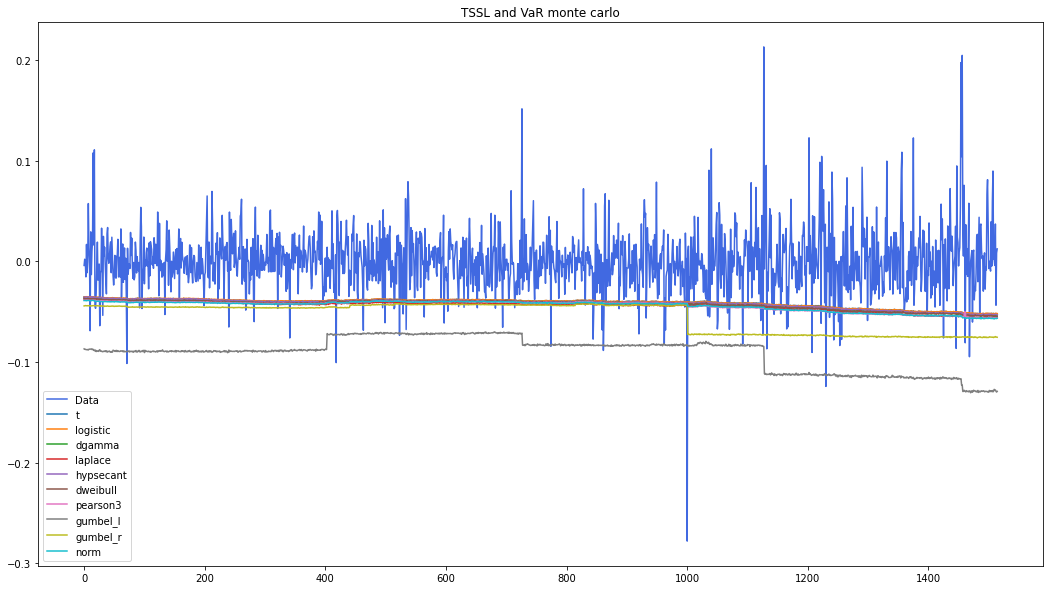

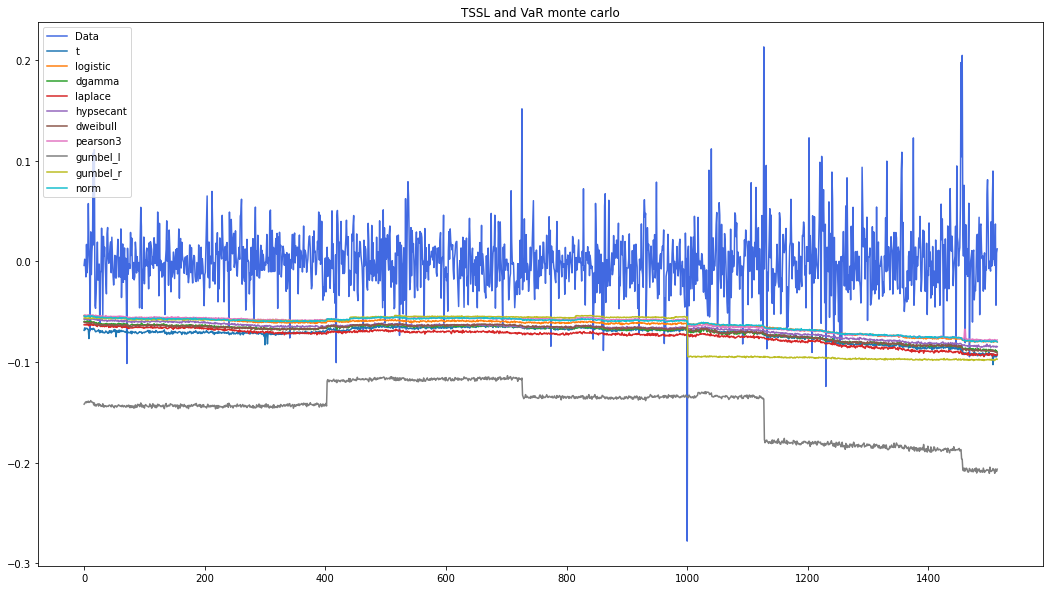

In [0]:

# Adjusting the size of matplotlib
import matplotlib as mpl
# matplotlib.style.use('default')
mpl.rc('figure', figsize=(18, 10))
mpl.__version__

# Adjusting the style of matplotlib



# .Profit_rate.iloc[1001:].plot(label='hi', color='royalblue')
# plt.legend()

for level_meaning in level_meanings:
    ax = data.iloc[:len(tssl[0.05][st.norm.name])].iloc[::-1].set_index(np.arange(len(tssl[0.05][st.norm.name]))).Profit_rate.plot(title='TSSL and VaR monte carlo', label='Data', color='royalblue')

    for dist in DISTRIBUTIONS:
        tssl[level_meaning][dist.name].Monte_carlo.plot(ax = ax, label='{}'.format(dist.name))
    plt.legend(loc='best')
    plt.show()

### Save result

In [0]:
data[['Date', 'Close', 'Profit_rate']].describe().to_csv('NAT_describe.csv')
result.to_csv('NAT_result.csv')
for level_meaning in level_meanings:
    for dist in DISTRIBUTIONS:
        tssl[level_meaning][dist.name].to_csv('huyto/NAT_{}%_{}.csv'.format(level_meaning, dist.name))
!zip -r /content/huyto.zip /content/huyto

  adding: content/huyto/ (stored 0%)
  adding: content/huyto/NAT_0.01%_dgamma.csv (deflated 62%)
  adding: content/huyto/NAT_0.05%_hypsecant.csv (deflated 62%)
  adding: content/huyto/NAT_0.05%_dgamma.csv (deflated 62%)
  adding: content/huyto/NAT_0.05%_dweibull.csv (deflated 62%)
  adding: content/huyto/NAT_0.05%_pearson3.csv (deflated 62%)
  adding: content/huyto/NAT_0.01%_hypsecant.csv (deflated 62%)
  adding: content/huyto/NAT_0.05%_laplace.csv (deflated 62%)
  adding: content/huyto/NAT_0.01%_gumbel_r.csv (deflated 63%)
  adding: content/huyto/NAT_0.01%_norm.csv (deflated 62%)
  adding: content/huyto/NAT_0.05%_gumbel_r.csv (deflated 63%)
  adding: content/huyto/NAT_0.01%_dweibull.csv (deflated 62%)
  adding: content/huyto/NAT_0.01%_gumbel_l.csv (deflated 62%)
  adding: content/huyto/NAT_0.05%_norm.csv (deflated 62%)
  adding: content/huyto/NAT_0.01%_t.csv (deflated 62%)
  adding: content/huyto/NAT_0.05%_t.csv (deflated 62%)
  adding: content/huyto/NAT_0.01%_laplace.csv (deflated 62